# Analysis of Classifier Data for CogSci

Lewis Baker
2017-2-3

These are the analyses conducted in the submission to CogSci17 by Baker, LoBue, Bonawitz and Shafto. From the abstract:

> Emotional state influences nearly every aspect of human cognition. However, coding emotional state is a costly process that relies on proprietary software or the subjective judgments of trained raters, highlighting the need for a reliable, automatic method of recognizing and labeling emotional expression. We demonstrate that machine learning methods can approach near-human levels for categorization of facial expression in naturalistic experiments. Our results show relative success of models on highly controlled stimuli and relative failure on less controlled images, and highlights the the need for real-world data for application to real-world experiments. We then test the potential of combining multiple freely available datasets to broadly categorize faces that vary across age, race, gender and photographic quality. 

Here I demonstrate how to replicate our figures and results. Note that all statistical analyses were performed in R, also found in this repository.

## Procedure

We trained a support vector machine classifier (SVM) on four different datasets:

* The Child Affective Facial Expression (CAFE) set
* Cohn-Kanade AU-Coded Expression Database, Version 2 (CK+)
* An uncurated set of Google images collected by research assistants (Google)
* A comprehensive dataset comprized of all the above datasets (ALL)

The classifier was trained on incrementally increasing sizes of training data from all three datasets individually and a comprehensive dataset trained from all sources. Most classification procedures use a k-folds or leave-one-out method, whereby a proportion of images are witheld at random from the training set for testing. However, because of dependencies within the training data (i.e., multiple emotional expressions by the same model), we had to perform a "leave-NP-out" method, in which 10 participants were removed from the dataset and all emotional expressions within that participant's file were tested. This resulted in sometimes uneven numbers of samples in training and testing, adressed below.

Images from the CAFE and Google datasets were validated by 100 and 87 adult human raters, respectively. We use human performance as a benchmark of classifier performance.

Each sample size by dataset was repeated 40 times with a new random selection of training and test data to approximate error. After 40 iterations, the sample size was increased by 100 and the process repeated until the dataset was exhausted.

The following analysis examines the output of the classifier with three main questions:

1. How do classifiers from each dataset imrpove with increasing training data?
2. How well does each classifier perform individually compared to the comrehensive dataset?
3. How does the comprehensive classifier compare to human performance accross emotional categories?

## Packages & Data

In [1]:
%pylab inline
import cv2
from os import system
import sys
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools
from sklearn import svm, metrics

/Library/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [13]:
sys.version

'2.7.12 |Anaconda 2.1.0 (x86_64)| (default, Jul  2 2016, 17:43:17) \n[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]'

In [3]:
cdata = pd.read_csv('CogSci Classifier Data 2017-1-26.csv',header=0)
cdata.loc[cdata.Source == 'Google'].head()

Our first step was to smooth out the sample sizes for visualization. Because of the "leave-NP-out" method, we have several irregularities in terms of the exact size of the dataset. For instance, there were only four rounds of the CK dataset, with training sample sizes of 100, 200, 300 and 400. However, because of stocastic processes involved with removing participants and not specific images, the number of discrete sample sizes is far larger than 4:

In [4]:
len(unique(cdata.loc[cdata.Source == 'CK'].PID)) 

427

We fix this by rounding to the nearest 100 place.

In [6]:
roundsets = []
roundsets = [int(round(s/100.0)*100) for s in cdata.SetSize.values]
cdata.SetSize.update(pd.Series(roundsets))
unique(cdata.SetSize)

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900])

The CAFE human validation is included with the classifier output. However, validation of the Google dataset occurred after the data was generated. We add that data here.

The second function excludes the cartoon emotional categories that were used as an attention check within the online experiment. 

In [8]:
hdata = pd.read_csv('online_rater_means.csv',header=0)
hdata = hdata.loc[hdata.Raters == 'Online'].loc[hdata.Set != 'Emoji']
hdata.head()

,Raters,Set,Emotion,Stimulus,Accuracy,Shared
3,Online,CAFE,Angry,angry_F-AA-02,0.500000,1
10,Online,CAFE,Angry,angry_F-AA-09,0.571429,1
16,Online,CAFE,Angry,angry_F-AA-14,0.555556,1
25,Online,CAFE,Angry,angry_F-AS-07,1.000000,1
29,Online,CAFE,Angry,angry_F-EA-01,0.909091,1


The human rater data is then added to the classifier data. This function could be optimized by only cycling through the Google and CAFE images

In [16]:
def addHumanData(output):
    # adds human data from each tested case to the output dataframe from the parallelized recognizer
    # has to be in dataframe form - call lists_to_dataframe first
    humanFileRef = '/Users/Lewis/Documents/Projects/Emotion Classifier/Online Rater Experiment/data/online_rater_means.csv'
    hdata = pd.read_csv(humanFileRef)
    hdata = hdata.loc[hdata.Raters == 'Online'].loc[hdata.Set != 'Emoji']
    ncases = len(output.PID)
    print('dataset loaded')
    for cnt, fname in enumerate(output.PID):
        if cnt == 0:
            if any(hdata.loc[hdata['Stimulus'] == fname]):
                hAccu = hdata.loc[hdata['Stimulus'] == fname]['Accuracy']
            else: #if there's no adult data (i.e., for google faces)
                hAccu = nan
        else:
            if any(hdata.loc[hdata['Stimulus'] == fname]):
                hAccu = np.append(hAccu,hdata.loc[hdata['Stimulus'] == fname]['Accuracy'])
            else: #if there's no adult data (i.e., for google faces)
                hAccu = np.append(hAccu,nan)
        if mod(cnt,10000) == 0:
            progress = ((cnt+1)/float(ncases))*100.0
            print('Progress: %3.3f' %progress)
    output['ValidAccu'] = hAccu
    return(output)

In [17]:
testdata = addHumanData(cdata)

dataset loaded
Progress: 0.001
Progress: 5.047
Progress: 10.094
Progress: 15.141
Progress: 20.187
Progress: 25.234
Progress: 30.281
Progress: 35.327
Progress: 40.374
Progress: 45.421
Progress: 50.467
Progress: 55.514
Progress: 60.561
Progress: 65.607
Progress: 70.654
Progress: 75.701
Progress: 80.747
Progress: 85.794
Progress: 90.841
Progress: 95.887


For cases in which we have two validation measures, the data is averaged accross raters and added as a third validation column

In [25]:
test2 = testdata.copy()
avgAccu = []
for i, v in enumerate(test2.ValidAccu):
    if pd.isnull(v): #if valid Accu is null
        if pd.isnull(test2.HumanAccu.ix[i]): #if human accu is null
            avgAccu.append(nan)
        else: #if valid is null but human is present
            avgAccu.append(test2.HumanAccu.ix[i])
    else: #if valid accu is present
        if pd.isnull(test2.HumanAccu.ix[i]): #if human accu is null
            avgAccu.append(v)
        else: #both valid and human accu
            avgAccu.append((test2.HumanAccu.ix[i]+v)/2.0)
test2['AvgAccu'] = avgAccu

# alright, now let's assign test2 to the main dataframe and get on with this
cdata = test2
cdata.head()

,Index,SetSize,PID,Emotion,EmotionCode,SVMPrediction,SVMPCode,SVMAccu,Source,Iter,HumanAccu,Run,ValidAccu,AvgAccu
0,0,100,neutral_F-AS-06,neutral,0,neutral,0,1,CAFE,1,0.75,CAFE Only,NaN,0.75
1,1,100,neutralopen_F-AS-06,neutral,0,neutral,0,1,CAFE,1,0.40,CAFE Only,NaN,0.40
2,2,100,neutral_F-EA-05b,neutral,0,neutral,0,1,CAFE,1,0.92,CAFE Only,NaN,0.92
3,3,100,neutralopen_F-EA-26,neutral,0,neutral,0,1,CAFE,1,0.00,CAFE Only,NaN,0.00
4,4,100,neutral_F-SA-05,neutral,0,neutral,0,1,CAFE,1,0.88,CAFE Only,NaN,0.88


## Exporting data for R analysis

In [14]:
# exporting for easy R analysis
cdata.to_csv('CogSci_with_validation.csv')

In [26]:
# overall by run by iteration
cdata11 = cdata.groupby(['Run','SetSize','Iter'], as_index=False).mean()
cdata11.to_csv('CogSci_run__iter_size.csv')
cdata11.head()

,Run,SetSize,Iter,Index,EmotionCode,SVMPCode,SVMAccu,HumanAccu,ValidAccu,AvgAccu
0,ALL,100,1,92.5,2.704301,2.951613,0.198925,0.610610,0.644073,0.622694
1,ALL,100,2,272.0,2.699422,2.387283,0.312139,0.656522,0.638408,0.635262
2,ALL,100,3,442.0,2.790419,2.724551,0.245509,0.680769,0.622611,0.638717
3,ALL,100,4,621.0,2.753927,2.659686,0.340314,0.603750,0.650028,0.617064
4,ALL,100,5,808.5,2.739130,2.543478,0.271739,0.657089,0.596176,0.610244


In [22]:
# by emotion by run
cdata2 = cdata.groupby(['Run','Source','Emotion','SetSize'], as_index=False).mean()
cdata2.to_csv('CogSci_run_emo_set.csv')
cdata2.head()

,Run,Source,Emotion,SetSize,Index,EmotionCode,SVMPCode,SVMAccu,Iter,HumanAccu,ValidAccu,AvgAccu
0,ALL,CAFE,angry,100,3475.736842,1.0,2.463938,0.276803,20.319688,0.640019,0.665534,0.628584
1,ALL,CAFE,angry,200,10491.822034,1.0,2.190678,0.385593,19.864407,0.652479,0.675809,0.642843
2,ALL,CAFE,angry,300,17661.338000,1.0,2.290000,0.362000,20.436000,0.651940,0.700439,0.643443
3,ALL,CAFE,angry,400,24776.888446,1.0,2.276892,0.350598,20.376494,0.674143,0.703638,0.666638
4,ALL,CAFE,angry,500,31929.433735,1.0,2.194779,0.409639,20.598394,0.668574,0.703462,0.660456


In [23]:
# by item
cdata3 = cdata.groupby(['PID', 'Source','Run','SetSize'], as_index=False).mean()
cdata3.to_csv('CogSci_by_item.csv')
cdata3.head()

,PID,Source,Run,SetSize,Index,EmotionCode,SVMPCode,SVMAccu,Iter,HumanAccu,ValidAccu,AvgAccu
0,CK_angry_S010,CK,ALL,100,3362.000000,1.0,1.75,0.5,19.000000,NaN,NaN,NaN
1,CK_angry_S010,CK,ALL,200,10745.500000,1.0,1.00,0.0,20.500000,NaN,NaN,NaN
2,CK_angry_S010,CK,ALL,300,18583.200000,1.0,0.60,0.2,24.800000,NaN,NaN,NaN
3,CK_angry_S010,CK,ALL,400,24597.000000,1.0,0.00,0.0,18.666667,NaN,NaN,NaN
4,CK_angry_S010,CK,ALL,500,33091.333333,1.0,0.00,0.0,26.333333,NaN,NaN,NaN


In [36]:
# 'All' Run data, by iteration and source
cdata4 = cdata.loc[cdata.SetSize== max(cdata.SetSize)]
cdata4 = cdata4.groupby(['Run','Source','SetSize','Iter','Emotion'], as_index=False).mean()
cdata4.to_csv('CogSci_all_run_max.csv')
cdata4.head()

,Run,Source,SetSize,Iter,Emotion,Index,EmotionCode,SVMPCode,SVMAccu,HumanAccu,ValidAccu,AvgAccu
0,ALL,CAFE,1900,1,angry,134951.973684,1.0,2.078947,0.473684,0.636316,0.748016,0.629712
1,ALL,CAFE,1900,1,disgust,135538.277778,2.0,1.861111,0.472222,0.628056,0.595184,0.615653
2,ALL,CAFE,1900,1,fearful,136710.653846,3.0,3.384615,0.346154,0.406154,0.372206,0.381151
3,ALL,CAFE,1900,1,happy,135205.022222,4.0,3.622222,0.800000,0.849111,0.916925,0.848812
4,ALL,CAFE,1900,1,neutral,135316.714286,0.0,1.500000,0.571429,0.654286,0.442539,0.635956


# Analysis

There were four main goals we wished to test. For brevity, only analyses 1, 3 & 4 were included in the manuscript.

1. How do classifiers from each dataset improve with increasing training data?
2. How does each classifier compare to human performance for each emotional category?
3. How well does each classifier perform individually compared to the comrehensive dataset?
4. How does the comprehensive classifier compare to human performance accross emotional categories?

## Analysis 1: How do classifiers from each dataset improve with increasing training data?

In [26]:
fdata1 = pd.melt(cdata,id_vars=['Source','Run','SetSize'],value_vars=['SVMAccu','AvgAccu'], 
                value_name='Accuracy',var_name='Classifier')
fdata1['ClassRun'] = fdata1.Run+'-'+ fdata1.Classifier
fdata1.loc[fdata1.Run == 'ALL','Run']= 'Comprehensive Model'
fdata1.head()

,Source,Run,SetSize,Classifier,Accuracy,ClassRun
0,CAFE,CAFE Only,100,SVMAccu,1.0,CAFE Only-SVMAccu
1,CAFE,CAFE Only,100,SVMAccu,1.0,CAFE Only-SVMAccu
2,CAFE,CAFE Only,100,SVMAccu,1.0,CAFE Only-SVMAccu
3,CAFE,CAFE Only,100,SVMAccu,1.0,CAFE Only-SVMAccu
4,CAFE,CAFE Only,100,SVMAccu,1.0,CAFE Only-SVMAccu


In [27]:
# Separating into human and SVM subsets
fhuman1 = fdata1.loc[fdata1.Classifier == 'AvgAccu'].copy()
fsvm1 = fdata1.loc[fdata1.Classifier == 'SVMAccu'].copy()

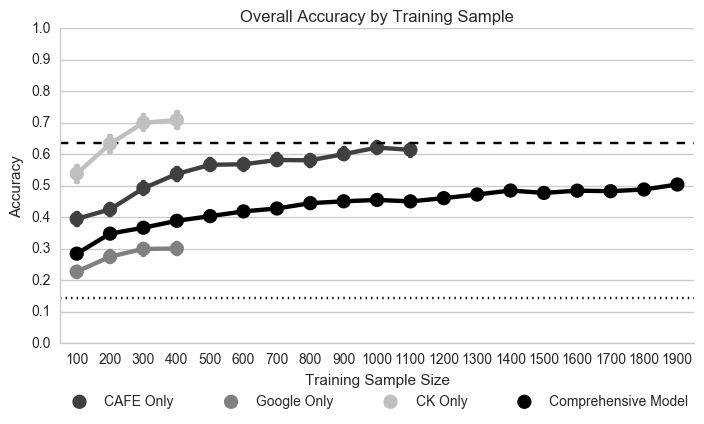

In [29]:
sns.set_style("whitegrid")

clrs = ['.25','.5','.75','.0']
g = sns.factorplot(x="SetSize", y="Accuracy",hue='Run', data=fsvm1,
                       capsize=.05, palette=clrs, size=4, aspect=1.8,jitter=True, legend=False, vmin=0, vmax=.5)


# plt.legend(bbox_to_anchor=(.65, .285), loc=2, borderaxespad=0.)
# plt.legend(bbox_to_anchor=(.65, .95), loc=2, borderaxespad=0.)
plt.legend(bbox_to_anchor=(0, -0.225,1,-0.225), loc=8,
           ncol=5, mode="expand", borderaxespad=0.)

# g.map(plt.clim,color-4,4)
# g.map(plt.clim, y=chance, ls=":", c="0")
# plt.clim(vmin=0,vmax=.5)
titles = ["Overall Accuracy by Training Sample", "bar", "buz"]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

chance = 1.0/7.0
humanAccu= np.mean(fhuman1.Accuracy)

g.fig.get_axes()[0].set_yticks(arange(0, 1.1, .1))
g.fig.get_axes()[0].set_xlabel("Training Sample Size")


plt.axhline(y=chance, ls=":", c="0")
plt.axhline(y=humanAccu, ls="--", c="0")

#NOTE: remove points for human accuracy -- add line for approximate average human accuracy accross all datasets
#NOTE: also include hline for chance performance.
# ax.set_title("Accuracy for CAFE Items by Classifier")

## Analysis 2: How does each classifier compare to human performance for each emotional category?

In [36]:
subCAFE = cdata.loc[cdata.Run == 'CAFE Only'].loc[cdata.SetSize == max(unique(cdata.loc[cdata.Run == 'CAFE Only'].SetSize))]
subGoogle = cdata.loc[cdata.Run == 'Google Only'].loc[cdata.SetSize == max(unique(cdata.loc[cdata.Run == 'Google Only'].SetSize))]
subCK = cdata.loc[cdata.Run == 'CK Only'].loc[cdata.SetSize == max(unique(cdata.loc[cdata.Run == 'CK Only'].SetSize))]
subALL = cdata.loc[cdata.Run == 'ALL'].loc[cdata.SetSize == max(unique(cdata.loc[cdata.Run == 'ALL'].SetSize))]

subMAX = pd.concat([subCAFE,subGoogle,subCK,subALL]) #max sample sizes per dataset
fdata2 = pd.melt(subMAX,id_vars=['Source','Run','Emotion'],value_vars=['SVMAccu','AvgAccu'], 
                value_name='Accuracy',var_name='Classifier')
fdata2['ClassRun'] = fdata2.Run.copy()
fdata2.ClassRun.loc[fdata2.Classifier == 'AvgAccu'] = 'Human'

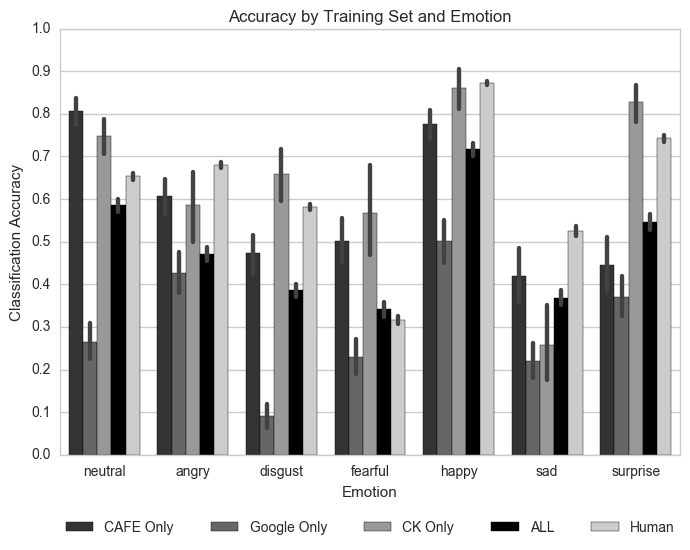

In [37]:
sns.set_style("whitegrid")

clrs = ['.2','.4','.6','.0','.8']

hueOrder = ['CAFE Only','Google Only','CK Only','ALL','Human']
ax = sns.barplot(x="Emotion", y="Accuracy", hue="ClassRun",hue_order=hueOrder, palette =clrs, data=fdata2)
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend(bbox_to_anchor=(0, -0.2,1,-0.2), loc=8,
           ncol=5, mode="expand", borderaxespad=0.)

ax.set_title("Accuracy by Training Set and Emotion")
ax.set_yticks(arange(0, 1.1, .1))
ax.set_ylabel("Classification Accuracy")

## Analysis 3: How does the comprehensive classifier compare to human performance accross emotional categories?

In [40]:
subCAFE = cdata.loc[cdata.Run == 'CAFE Only'].loc[cdata.SetSize == max(unique(cdata.loc[cdata.Run == 'CAFE Only'].SetSize))]
subGoogle = cdata.loc[cdata.Run == 'Google Only'].loc[cdata.SetSize == max(unique(cdata.loc[cdata.Run == 'Google Only'].SetSize))]
subCK = cdata.loc[cdata.Run == 'CK Only'].loc[cdata.SetSize == max(unique(cdata.loc[cdata.Run == 'CK Only'].SetSize))]
subALL = cdata.loc[cdata.Run == 'ALL'].loc[cdata.SetSize == max(unique(cdata.loc[cdata.Run == 'ALL'].SetSize))]

subMAX = pd.concat([subCAFE,subGoogle,subCK,subALL]) #max sample sizes per dataset


fdata2 = pd.melt(subMAX,id_vars=['Source','Run','Emotion'],value_vars=['SVMAccu'], 
                value_name='Accuracy',var_name='Classifier')
# fdata2['ClassRun'] = fdata2.Run.copy()
# fdata2.ClassRun.loc[fdata2.Classifier == 'AvgAccu'] = 'Human'
# fdata3 = fdata2.copy()
# fdata3['Source'] = 'ALL'

runcomp = []
for run in fdata2.Run.tolist():
    if run == 'ALL':
        runcomp.append("Comprehensive Model")
    else:
        runcomp.append("Within-Set Model")

fdata2['RunComp'] = runcomp

# fdata4 = pd.concat([fdata2,fdata3],ignore_index=True)
# fdata4.head()


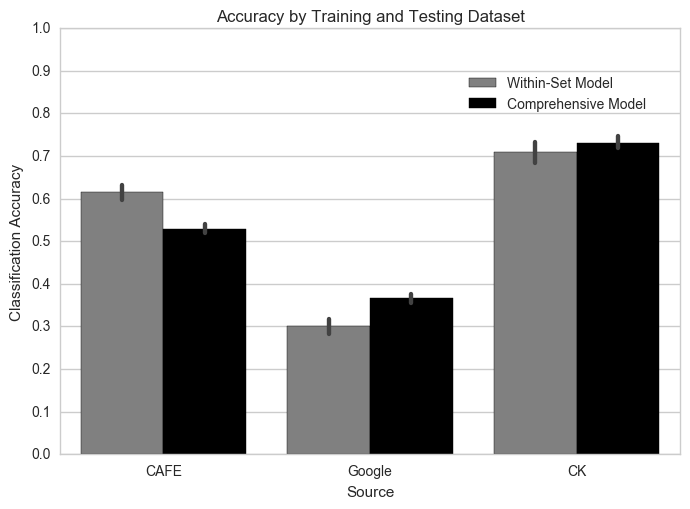

In [41]:
sns.set_style("whitegrid")
clrs = ['.5','.0']

# hueOrder = ['CAFE Only','Google Only','CK Only','ALL','Human']
ax = sns.barplot(x="Source", y="Accuracy", hue="RunComp",palette = clrs, data=fdata2)
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.legend(bbox_to_anchor=(0, -0.2,1,-0.2), loc=8,
#            ncol=5, mode="expand", borderaxespad=0.)

plt.legend(bbox_to_anchor=(.65, .90), loc=2, borderaxespad=0.)

ax.set_title("Accuracy by Training and Testing Dataset")
ax.set_yticks(arange(0, 1.1, .1))
ax.set_ylabel("Classification Accuracy")

# Analysis 4: How does the comprehensive classifier compare to human performance accross emotional categories?

In [42]:
# "All" Run data by iteration and source vs human accuracy
cdata4 = cdata.loc[cdata.SetSize== max(cdata.SetSize)]
# cdata4 = cdata.loc[cdata.Source == 'Google']

cdata41 = cdata4.copy()
cdata42 = cdata4.copy()

popHuman = cdata41.pop('AvgAccu')

del cdata41['ValidAccu']
del cdata41['HumanAccu']

del cdata42['ValidAccu']
del cdata42['HumanAccu']
del cdata42['AvgAccu']

cdata41.rename(columns = {'SVMAccu':'Accu'},inplace = True)
cdata41['Classifier'] = 'Comprehensive Model'

cdata42.rename(columns = {'SVMAccu':'Accu'},inplace = True)
cdata42['Accu'] = popHuman
cdata42['Classifier'] = 'Human'

cdata4 = pd.concat([cdata41,cdata42])


cdata4 = cdata4.groupby(['Run','SetSize','Classifier','Iter','Emotion'], as_index=False).mean()
# cdata4.to_csv('CogSci_all_vs_human_emo.csv')

,Run,SetSize,Classifier,Iter,Emotion,Index,EmotionCode,SVMPCode,Accu
0,ALL,1900,Comprehensive Model,1,angry,135638.308642,1.0,2.024691,0.469136
1,ALL,1900,Comprehensive Model,1,disgust,135136.409639,2.0,2.156627,0.349398
2,ALL,1900,Comprehensive Model,1,fearful,135850.225806,3.0,3.096774,0.403226
3,ALL,1900,Comprehensive Model,1,happy,135092.439560,4.0,3.505495,0.736264
4,ALL,1900,Comprehensive Model,1,neutral,135379.725490,0.0,1.647059,0.500000
5,ALL,1900,Comprehensive Model,1,sad,135785.050847,5.0,2.966102,0.372881
6,ALL,1900,Comprehensive Model,1,surprise,135246.320000,6.0,4.680000,0.586667
7,ALL,1900,Comprehensive Model,2,angry,136093.987500,1.0,1.975000,0.462500
8,ALL,1900,Comprehensive Model,2,disgust,135488.405063,2.0,2.278481,0.430380
9,ALL,1900,Comprehensive Model,2,fearful,135905.861538,3.0,3.446154,0.323077


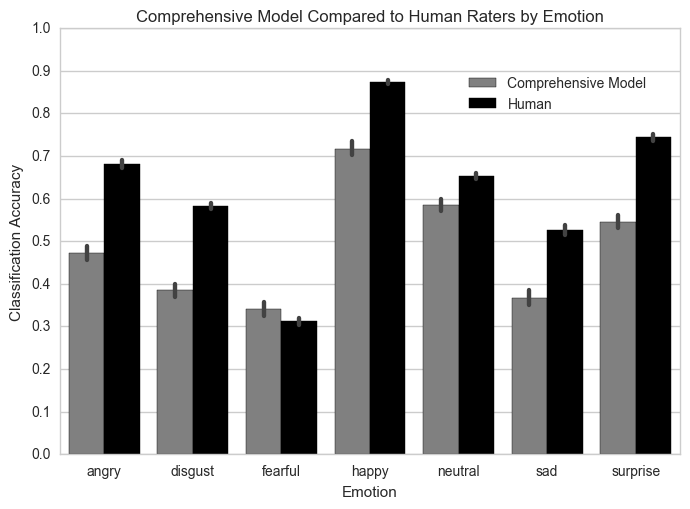

In [43]:
sns.set_style("whitegrid")
clrs = ['.5','.0']

# hueOrder = ['CAFE Only','Google Only','CK Only','ALL','Human']
ax = sns.barplot(x="Emotion", y="Accu", hue="Classifier",palette = clrs, data=cdata4)
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.legend(bbox_to_anchor=(0, -0.2,1,-0.2), loc=8,
#            ncol=5, mode="expand", borderaxespad=0.)

plt.legend(bbox_to_anchor=(.65, .90), loc=2, borderaxespad=0.)

ax.set_title("Comprehensive Model Compared to Human Raters by Emotion")
ax.set_yticks(arange(0, 1.1, .1))
ax.set_ylabel("Classification Accuracy")